# Fishy Turbo

https://www.linnsoft.com/techind/fishy-turbo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AAPL'
start = '2018-09-01'
end = '2019-01-01'

# Read data 
df = yf.download(symbol,start,end)

# View Columns
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-04,57.102501,57.294998,56.657501,57.090000,54.461617,109560400
2018-09-05,57.247501,57.417500,56.275002,56.717499,54.106270,133332000
2018-09-06,56.557499,56.837502,55.325001,55.775002,53.207161,137160000
2018-09-07,55.462502,56.342499,55.177502,55.325001,52.777878,150479200
2018-09-10,55.237499,55.462502,54.117500,54.582500,52.069561,158066000


In [3]:
# Calculate RSI
def RSI(data, window):
    delta = data['Adj Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    avg_gain = up.rolling(window=window, min_periods=1).mean()
    avg_loss = down.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate weighted moving average
def weighted_moving_average(data, window):
    weights = np.arange(1, window + 1)
    wma = data.rolling(window).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma

# Calculate Fishy Turbo
def fishy_turbo(rsi, window):
    x = weighted_moving_average(0.1 * (rsi - 50), window)
    fishy_turbo_val = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
    return fishy_turbo_val

# Parameters
rsi_window = 6
wma_window = 6

# Compute RSI
df['RSI'] = RSI(df, rsi_window)

# Compute Fishy Turbo
df['Fishy Turbo'] = fishy_turbo(df['RSI'], wma_window)

In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,Fishy Turbo
Date,,,,,,,,
2018-09-04,57.102501,57.294998,56.657501,57.090000,54.461617,109560400,NaN,NaN
2018-09-05,57.247501,57.417500,56.275002,56.717499,54.106270,133332000,0.0,NaN
2018-09-06,56.557499,56.837502,55.325001,55.775002,53.207161,137160000,0.0,NaN
2018-09-07,55.462502,56.342499,55.177502,55.325001,52.777878,150479200,0.0,NaN
2018-09-10,55.237499,55.462502,54.117500,54.582500,52.069561,158066000,0.0,NaN


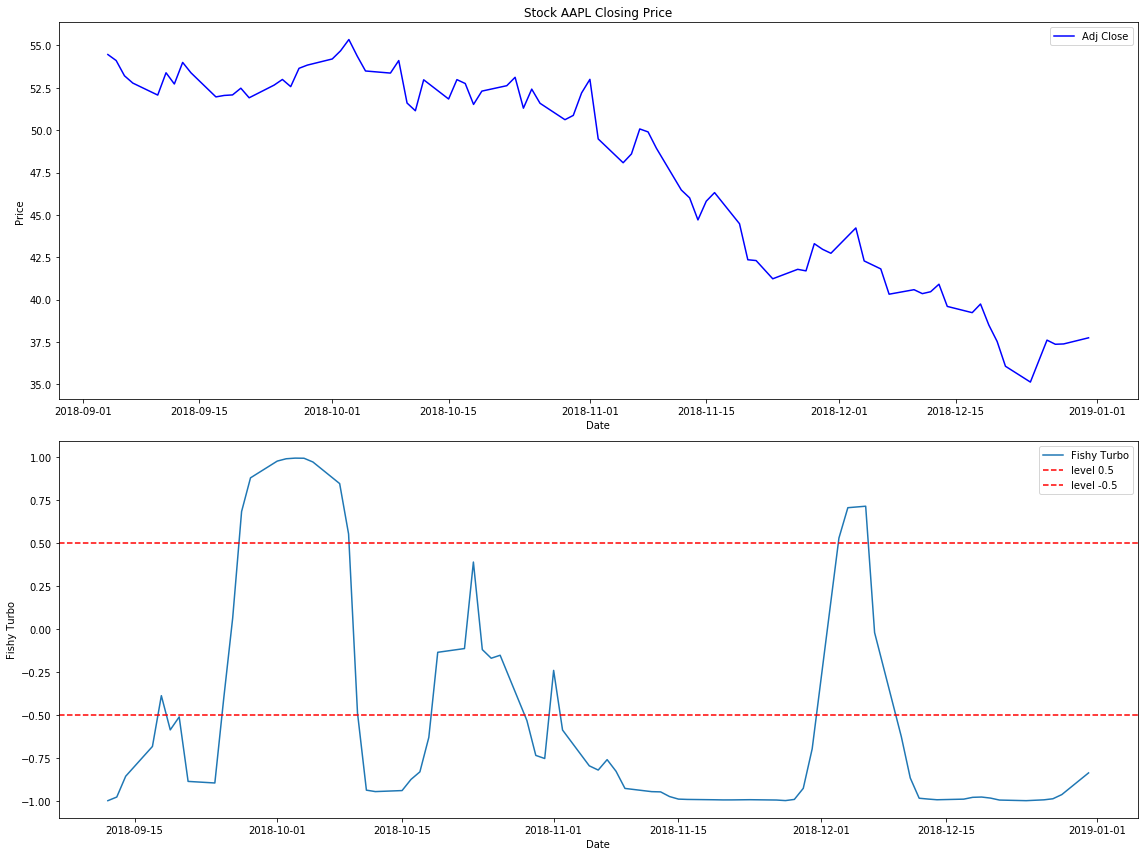

In [5]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(df['Adj Close'], label='Adj Close', color='blue')
ax1.set_title('Stock ' + symbol + ' Closing Price')
ax1.legend(loc='best')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['Fishy Turbo'], label='Fishy Turbo')
ax2.axhline(y=0.5, color='r', linestyle='--', label='level 0.5')
ax2.axhline(y=-0.5, color='r', linestyle='--', label='level -0.5')
ax2.set_ylabel('Fishy Turbo')
ax2.set_xlabel('Date')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

## Candlestick with Fishy Turbo

In [6]:
from matplotlib import dates as mdates
import datetime as dt

dfc = df.copy()
dfc['VolumePositive'] = dfc['Open'] < dfc['Adj Close']
#dfc = dfc.dropna()
dfc = dfc.reset_index()
dfc['Date'] = pd.to_datetime(dfc['Date'])
dfc['Date'] = dfc['Date'].apply(mdates.date2num)
dfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,Fishy Turbo,VolumePositive
0,736941.0,57.102501,57.294998,56.657501,57.090000,54.461617,109560400,NaN,NaN,False
1,736942.0,57.247501,57.417500,56.275002,56.717499,54.106270,133332000,0.0,NaN,False
2,736943.0,56.557499,56.837502,55.325001,55.775002,53.207161,137160000,0.0,NaN,False
3,736944.0,55.462502,56.342499,55.177502,55.325001,52.777878,150479200,0.0,NaN,False
4,736947.0,55.237499,55.462502,54.117500,54.582500,52.069561,158066000,0.0,NaN,False


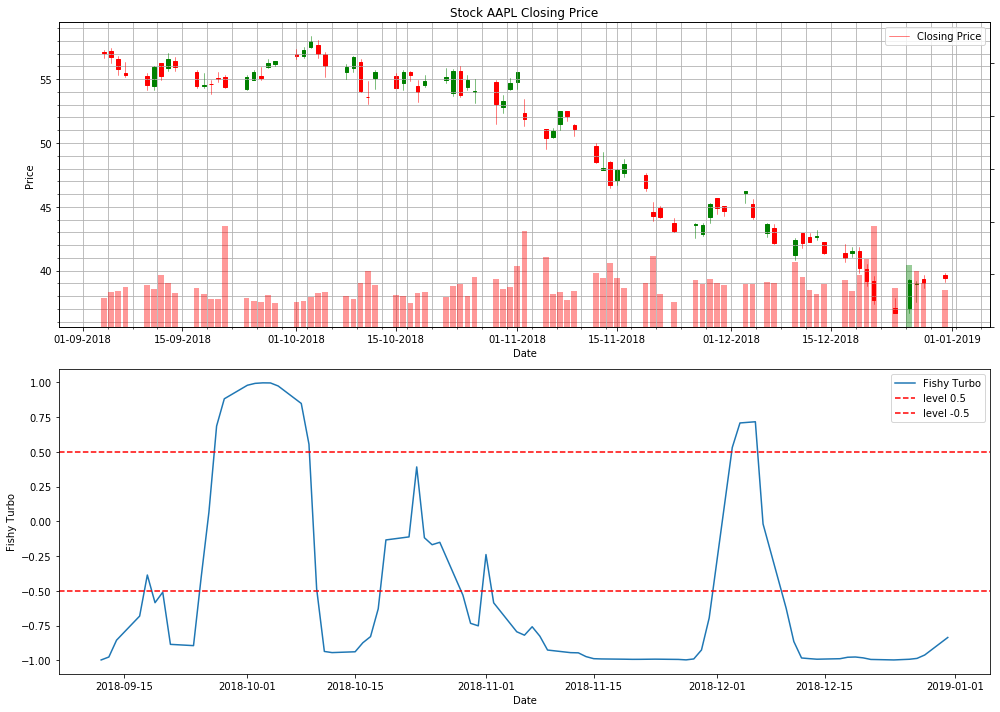

In [7]:
from mplfinance.original_flavor import candlestick_ohlc

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(2, 1, 1)
candlestick_ohlc(ax1, dfc[['Date', 'Open', 'High', 'Low', 'Close']].values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis_date()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3 * dfc.Volume.max())
ax1.set_title('Stock ' + symbol + ' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')
ax1.legend(['Closing Price'], loc='best')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['Fishy Turbo'], label='Fishy Turbo')
ax2.axhline(y=0.5, color='r', linestyle='--', label='level 0.5')
ax2.axhline(y=-0.5, color='r', linestyle='--', label='level -0.5')
ax2.set_ylabel('Fishy Turbo')
ax2.set_xlabel('Date')
ax2.legend(loc='best')

plt.tight_layout()
plt.show()

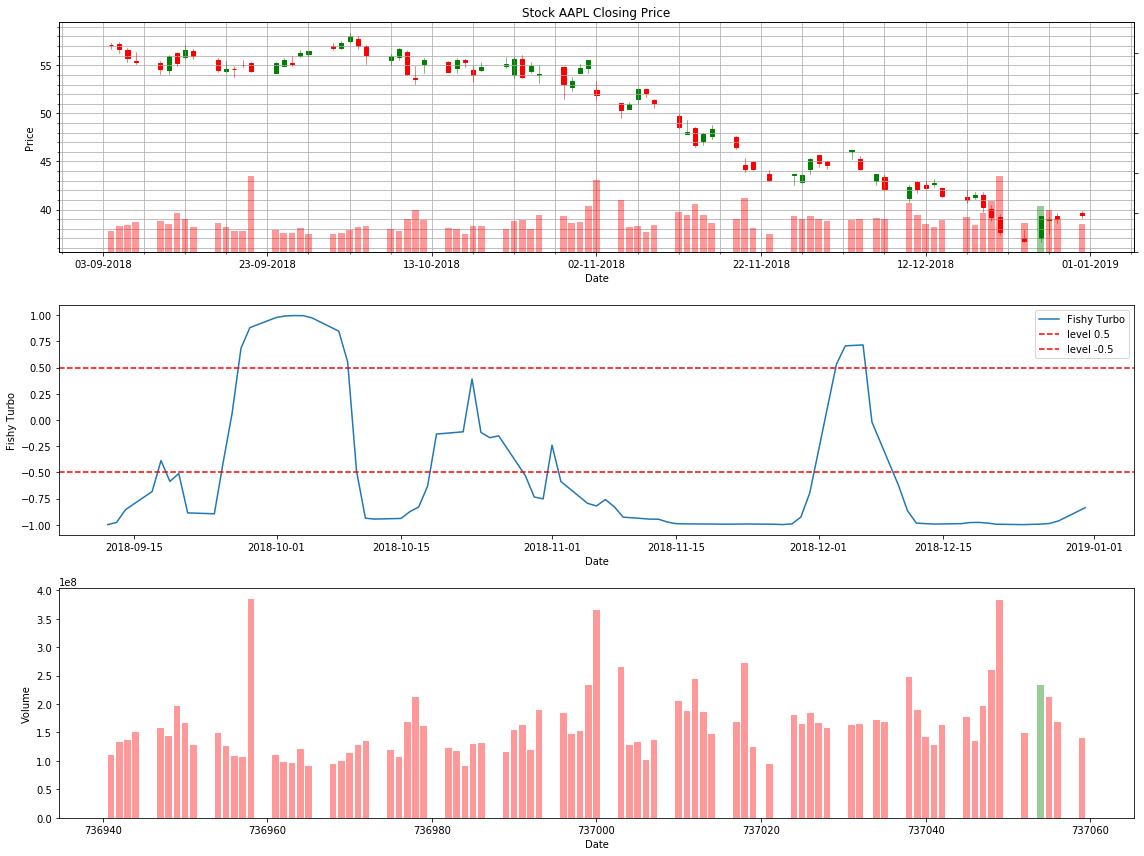

In [8]:
fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot(3, 1, 1)
candlestick_ohlc(ax1,dfc.values, width=0.5, colorup='g', colordown='r', alpha=1.0)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax1.grid(True, which='both')
ax1.minorticks_on()
ax1v = ax1.twinx()
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax1v.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax1v.axes.yaxis.set_ticklabels([])
ax1v.set_ylim(0, 3*df.Volume.max())
ax1.set_title('Stock '+ symbol +' Closing Price')
ax1.set_ylabel('Price')
ax1.set_xlabel('Date')

ax2 = plt.subplot(3, 1, 2)
ax2.plot(df['Fishy Turbo'], label='Fishy Turbo')
ax2.axhline(y=0.5, color='r', linestyle='--', label='level 0.5')
ax2.axhline(y=-0.5, color='r', linestyle='--', label='level -0.5')
ax2.set_ylabel('Fishy Turbo')
ax2.set_xlabel('Date')
ax2.legend(loc='best')

ax3 = plt.subplot(3, 1, 3)
colors = dfc.VolumePositive.map({True: 'g', False: 'r'})
ax3.bar(dfc.Date, dfc['Volume'], color=colors, alpha=0.4)
ax3.set_ylabel('Volume')
ax3.set_xlabel('Date')

plt.tight_layout()
plt.show()